<h1>Stroke Model Trainer Notebook</h1>
<h3>Training the model based on data scraped from the US Census Bureau</h3>
<h2><b>IMPORTANT:</b><br><span style="color:red;">This product uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.</span></h2>

<ol>
    <li>Split the data into training, test, and validation sets (done in a different notebook)</li>
    <ul>
        <li>4 fold cross validation - 80% of the data with training = 60%, validation = 20%</li>
        <li>Test = 20%</li>
    </ul>
    <li>Train the model based on broadband internet only, normalize y value, minimize MSE</li>
    <li>Use LASSO regularizatio|n to eliminate unecessary features from the theta vector</li>
    <li>Retrain the model with demographic features added in</li>
    <li>Retrain the model with economic features added in</li>
    <li>Retrain the model with social features added in</li>
</ol>

In [3]:
#Imports
#Data manipulation/training
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

#Visualization
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore') #Turn off warnings

<h2>Defining Helper Functions and Classes</h2>

In [4]:
class Transformation:
    """Transformation class to represent the transformation on one variable"""
    
    def __init__(self, transformation, transformation_name, inverse, inverse_name):
        """
        Parameters
        ----------
        transformation : def (x: arraylike<float>) -> arraylike<float>
            the transformation function to apply to an float array
            
        transformation_name : string
            the name of the transformation
            
        inverse : def (x: arraylike<float>) -> arraylike<float>
            the inverse function which can undo the transformation
            
        inverse_name : string
            the name of the inverse transformation
        """
        
        self.transformation = transformation
        self.transformation_name = transformation_name
        self.inverse = inverse
        self.inverse_name = inverse_name
        
    def chain(self, T2):
        transformation = lambda x: self.transformation(T2.transformation(x))
        transformation_name = self.transformation_name + T2.transformation_name
        inverse = lambda x: T2.inverse(self.inverse(x))
        inverse_name = T2.inverse_name + self.inverse_name
        return Transformation(transformation, transformation_name, inverse, inverse_name)

"""Utility Transformation objects"""
no_transformation = Transformation(lambda x: x, "", lambda x: x, "")
square = Transformation(lambda x: x**2, "The Square of", lambda x: x**0.5, "The Square Root of")
cube = Transformation(lambda x: x**3, "The Cube of", lambda x: x**(1/3), "The Cube Root of")
fourth = Transformation(lambda x: x**4, "The Fourth Power of", lambda x: x**0.25, "The Fourth Root of")
square_root = Transformation(lambda x: x**0.5, "The Square Root of", lambda x: x**2, "The Square of")
cube_root = Transformation(lambda x: x**(1/3), "The Cube Root of", lambda x: x**3, "The Cube of")
fourth_root = Transformation(lambda x: x**0.25, "The Fourth Root of", lambda x: x**4, "The Fourth Power of")
log = Transformation(lambda x: np.log(x), "The Natural Log of", lambda x: np.exp(x), "e to the Power of")
e_power = Transformation(lambda x: np.exp(x), "e to the Power of", lambda x: np.log(x), "The Natural Log of")

"""Defining the Y feature"""
Y_name = "Individuals Age 18+ who Experienced Stroke (%)"

def wrap_label(axis_name):
    """Wraps an label that is too long by adding newline characters
    
    Parameters
    ----------
    axis_name: string
    """
    words = axis_name.split()
    final_label = ""
    for i in range(len(words)):
        if i % 9 == 0 and i != 0:
            final_label += "\n"
        final_label += f"{words[i]} "
    return final_label

def plot_relationship(X_feature, Y, X_transformation=no_transformation, Y_transformation=no_transformation, imp_val=0):
    """Plots the relationship between an (optionally) transformation X feature and Y outcome
    
    If no transformation object is passed in, it assumed no transformation
    
    Parameters
    ----------
    X_feature : arraylike<float>
        The predictor variable
    
    Y : arraylike<float>
        The outcome variable
    
    X_transformation : Transformation
        The Transformation to apply to the X_feature
    
    Y_transformation : Transformation
        The Transformation to apply to the Y_feature
        
    Return Value
    ------------
    None
    """
    X_feature = impute_col(X_feature, imp_val)
    X_transformed = X_transformation.transformation(X_feature)
    Y_transformed = Y_transformation.transformation(Y)
    x_axis_name = f"{X_transformation.transformation_name} {X_feature.name}"
    y_axis_name = f"{Y_transformation.transformation_name} {Y.name}"
    fig_data = pd.DataFrame({x_axis_name : X_transformed, y_axis_name: Y_transformed})
    fig = sns.lmplot(data=fig_data, 
                     x=x_axis_name, 
                     y=y_axis_name, 
                     height=10, 
                     scatter_kws={
                         's': 0.7, 
                         'alpha': 0.4
                     },
                    )
    fig.set_xlabels(wrap_label(x_axis_name), fontsize=18)
    fig.set_ylabels(y_axis_name, fontsize=18)
    
def impute(df, x_col, impute_num):
    df = df.copy()
    mean_value = df[x_col].mean()
    df[x_col] = df[x_col].replace(impute_num, mean_value)
    return df

def impute_col(arr, impute_num):
    arr = arr.copy()
    arr[arr == impute_num] = np.mean(arr)
    return arr

def plot_residuals(X_feature, Y, X_transformation=no_transformation, Y_transformation=no_transformation, axis="X"):
    """Plots the residuals on a model trained on an (optionally) transformed X feature and Y outcome
    
    If no transformation object is passed in, it assumed no transformation
    
    Parameters
    ----------
    X_feature : arraylike<float>
        The predictor variable
    
    Y : arraylike<float>
        The outcome variable
    
    X_transformation : Transformation
        The Transformation to apply to the X_feature
    
    Y_transformation : Transformation
        The Transformation to apply to the Y_feature
        
    Return Value
    ------------
    None
    """
    X_transformed = X_transformation.transformation(X_feature)
    Y_transformed = Y_transformation.transformation(Y)
    y_axis_name = f"{Y_transformation.transformation_name} {Y.name}"
    x_axis_name = f"{X_transformation.transformation_name} {X_feature.name}"
    design_matrix = pd.DataFrame({x_axis_name: X_transformed})
    model = LinearRegression()
    model.fit(design_matrix, Y_transformed)
    predictions = model.predict(design_matrix)
    residuals = Y - Y_transformation.inverse(predictions)
    if axis == "X":
        fig_data = pd.DataFrame({x_axis_name : X_transformed, "Residual": residuals})
        fig = sns.lmplot(data=fig_data, 
                         x=x_axis_name, 
                         y="Residual", 
                         height=10, 
                         scatter_kws={
                             's': 0.7, 
                             'alpha': 0.4
                         },
                        )
        fig.set_xlabels(wrap_x_label(x_axis_name), fontsize=18)
        fig.set_ylabels("Residual", fontsize=18)
    else:
        fig_data = pd.DataFrame({Y.name: Y, "Residual": residuals})
        fig = sns.lmplot(data=fig_data, 
                         x=Y.name, 
                         y="Residual", 
                         height=10, 
                         scatter_kws={
                             's': 0.7, 
                             'alpha': 0.4
                         },
                        )
        fig.set_xlabels(wrap_x_label(y_axis_name), fontsize=18)
        fig.set_ylabels("Residual", fontsize=18)

def rmse(actual, predicted):
    """Computes the RMSE for an actual and predicted Y and Y hat
    
    Parameters
    ----------
    actual: arraylike<float>
        Y vector for a model
    
    predicted: arraylike<float>
        Y hat vector for a model
        
    Constraints
    -----------
    len(actual) == len(predicted)
    
    Return Value
    ------------
    float
    """
    return np.sqrt(np.mean((actual - predicted) ** 2))

def get_features(feature_set):
    """Returns a list with all the features based on the feature_Set
    
    Parameters
    ----------
    feature_set: list<string>
        The selected features for the model (out of 'initial', 'economic', 'social', and 'demographic'
    
    Return Value
    ------------
    list<string>
    """
    
    #Selecting the features
    feature_list = []
    if "initial" in feature_set:
        feature_list.extend(initial_features)
    if "social" in feature_set:
        feature_list.extend(social_features)
    if "demographic" in feature_set:
        feature_list.extend(demographic_features)
    if "economic" in feature_set:
        feature_list.extend(economic_features)
    
    return feature_list
        
def train_model(X, Y, Y_transformation=no_transformation):
    """Trains the model based on a preprocessed X matrix and Y vector
    
    Prints the training error as well as validation error across 4 folds
    
    Parameters
    ----------
    X: DataFrame
        The preprocessed design matrix for the model
        
    Y: arraylike<float>
        The outcome variable to be predicted
        
    Y_transformation: Transformation
        A transformation to apply to the Y value and to unapply to the predictions
    
    Return Value
    ------------
    None
    """
    
    model = LinearRegression()
    cross_validation = KFold(n_splits=4, shuffle=True, random_state=43)
    Y_t = Y_transformation.transformation(Y)
    model.fit(X, Y_t)
    train_predictions = Y_transformation.inverse(model.predict(X))
    train_error = rmse(Y, train_predictions)
    print(f"Training error: {train_error}")
    fold_counter = 1
    avg_cv_error = 0
    for train, val in cross_validation.split(X, Y_t):
        X_train = X.loc[X.index[train]]
        X_val = X.loc[X.index[val]]
        Y_train = Y_t.loc[Y_t.index[train]]
        Y_val = Y_t.loc[Y_t.index[val]]            
        model = LinearRegression()
        model.fit(X_train, Y_train)
        predictions = Y_transformation.inverse(model.predict(X_val))
        fold_rmse = rmse(Y_transformation.inverse(Y_val), predictions)
        print(f"Fold {fold_counter} validation error: {fold_rmse}")
        fold_counter += 1
        avg_cv_error += fold_rmse
    print(f"Average Cross Validation Error: {avg_cv_error / (fold_counter - 1)}")

In [5]:
X_train = pd.read_csv("./X_train_val.csv", index_col="ZCTA")
Y_train = pd.read_csv("./Y_train_val.csv", index_col="ZCTA")[[Y_name]]
cross_validation = KFold(n_splits=4)
with open('./codebooks/initial_features.txt', 'r') as file:
    initial_features =  [line.strip() for line in file.readlines()]
with open('./codebooks/economic_features.txt', 'r') as file:
    economic_features = [line.strip() for line in file.readlines()]
with open('./codebooks/demographic_features.txt', 'r') as file:
    demographic_features = [line.strip() for line in file.readlines()]
with open('./codebooks/social_features.txt', 'r') as file:
    social_features = [line.strip() for line in file.readlines()]

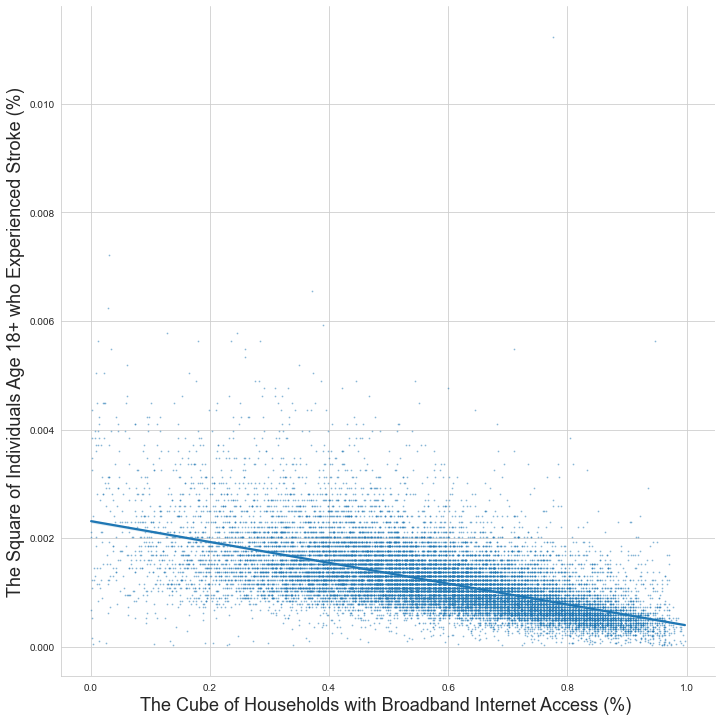

In [54]:
plot_relationship(X_train["Households with Broadband Internet Access (%)"], 
                  Y_train[Y_name],
                  X_transformation=cube,
                 Y_transformation=square)

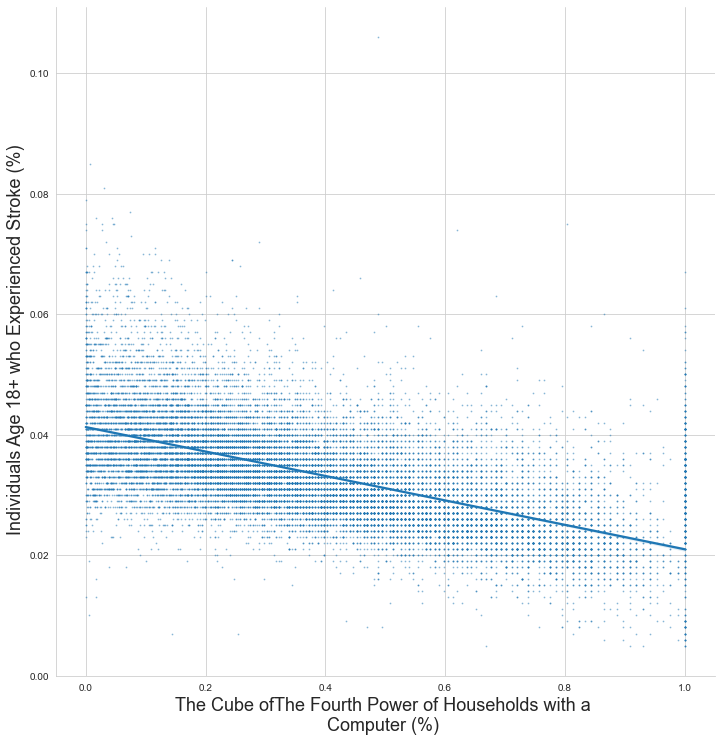

In [34]:
plot_relationship(X_train['Households with a Computer (%)'],
                  Y_train[Y_name],
                  X_transformation=cube.chain(fourth),
                  imp_val=0)

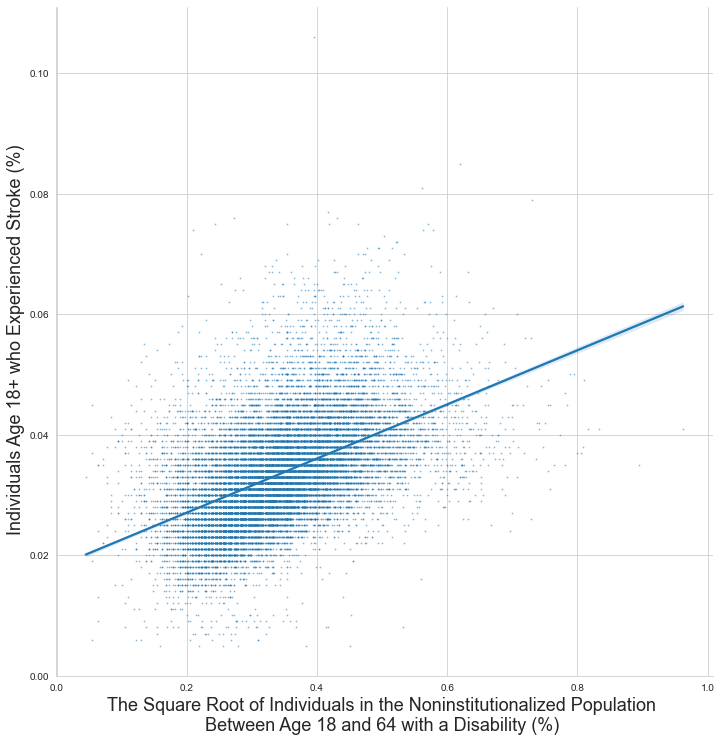

In [40]:
plot_relationship(X_train['Individuals in the Noninstitutionalized Population Between Age 18 and 64 with a Disability (%)'],
                  Y_train[Y_name],
                  X_transformation=square_root,
                  imp_val=0)

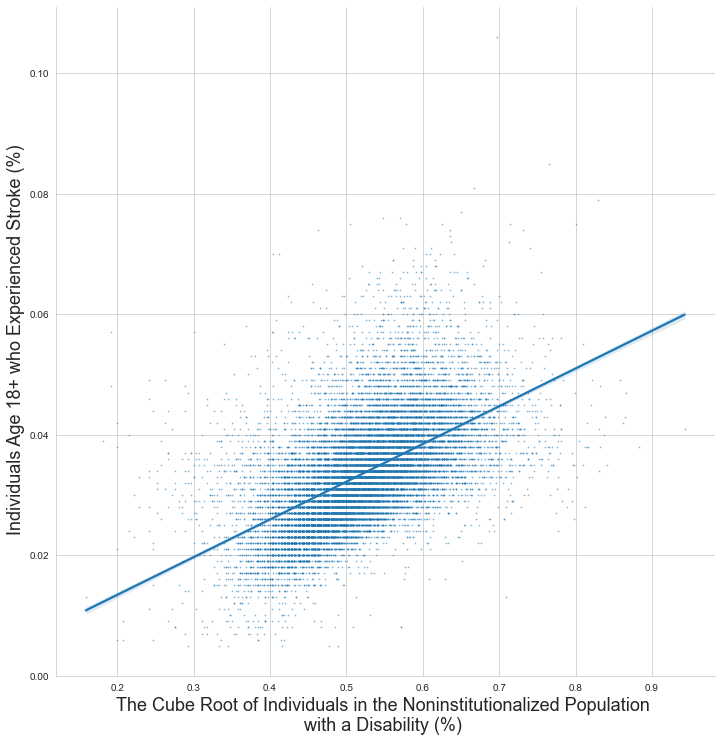

In [56]:
plot_relationship(X_train['Individuals in the Noninstitutionalized Population with a Disability (%)'],
                  Y_train[Y_name],
                  X_transformation=cube_root,
                  imp_val=0)

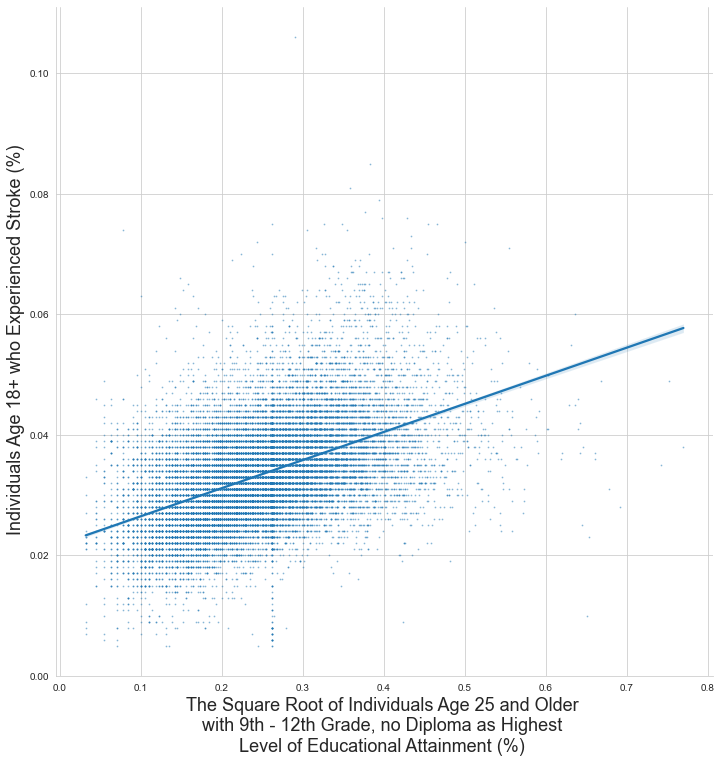

In [58]:
plot_relationship(X_train['Individuals Age 25 and Older with 9th - 12th Grade, no Diploma as Highest Level of Educational Attainment (%)'],
                  Y_train[Y_name],
                  X_transformation=square_root,
                  imp_val=0)

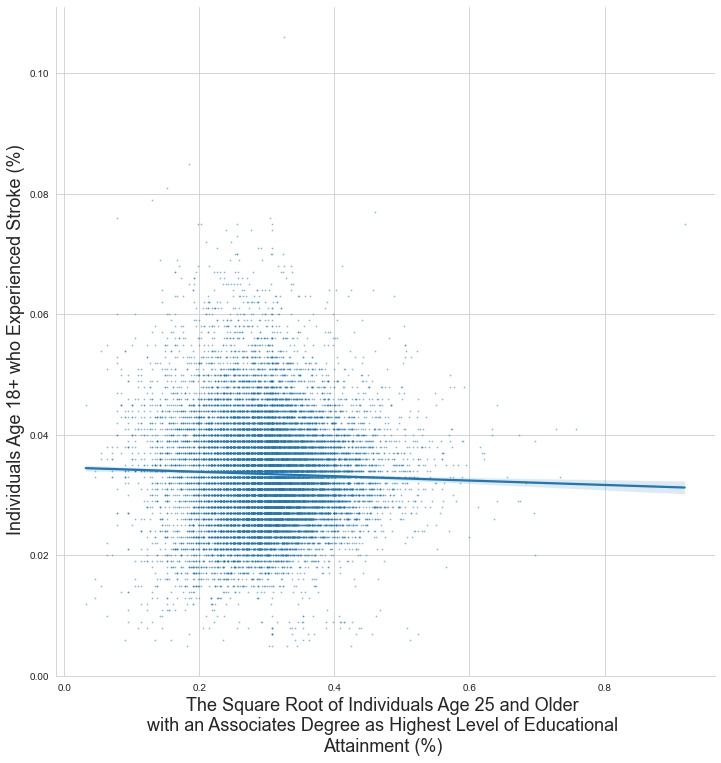

In [60]:
plot_relationship(X_train['Individuals Age 25 and Older with an Associates Degree as Highest Level of Educational Attainment (%)'],
                  Y_train[Y_name],
                  X_transformation=square_root,
                  imp_val=0)

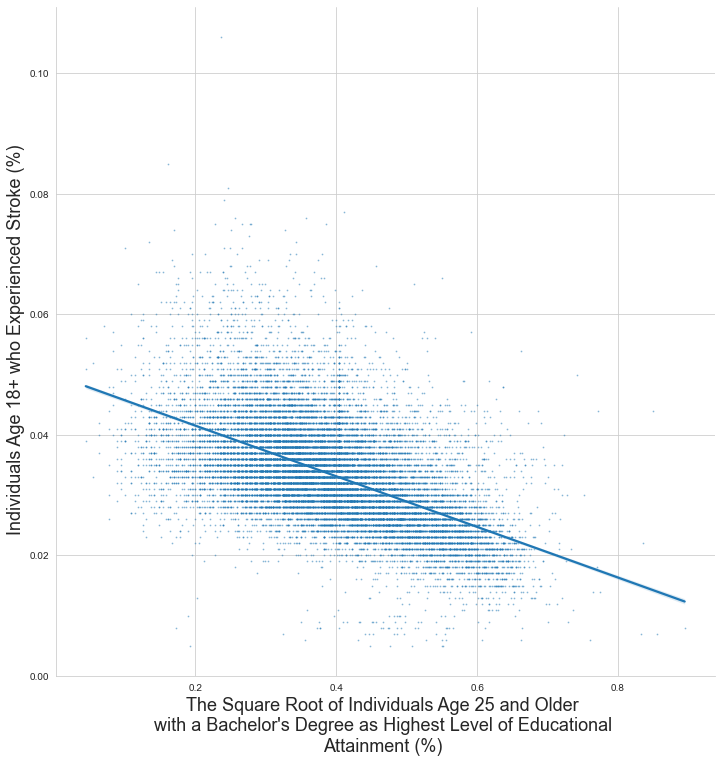

In [62]:
plot_relationship(X_train["Individuals Age 25 and Older with a Bachelor's Degree as Highest Level of Educational Attainment (%)"],
                  Y_train[Y_name],
                  X_transformation=square_root,
                  imp_val=0)

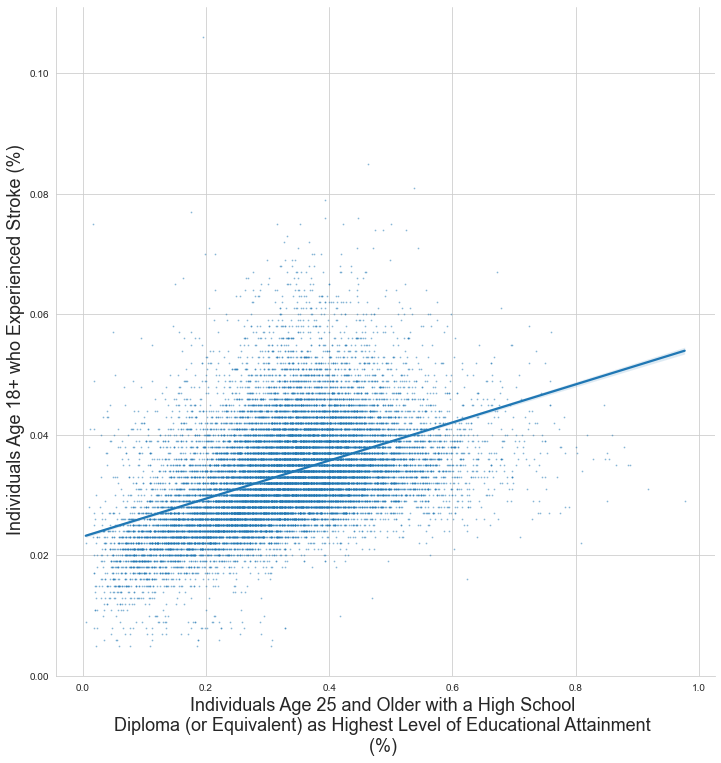

In [67]:
plot_relationship(X_train['Individuals Age 25 and Older with a High School Diploma (or Equivalent) as Highest Level of Educational Attainment (%)'],
                  Y_train[Y_name],
                  imp_val=0)

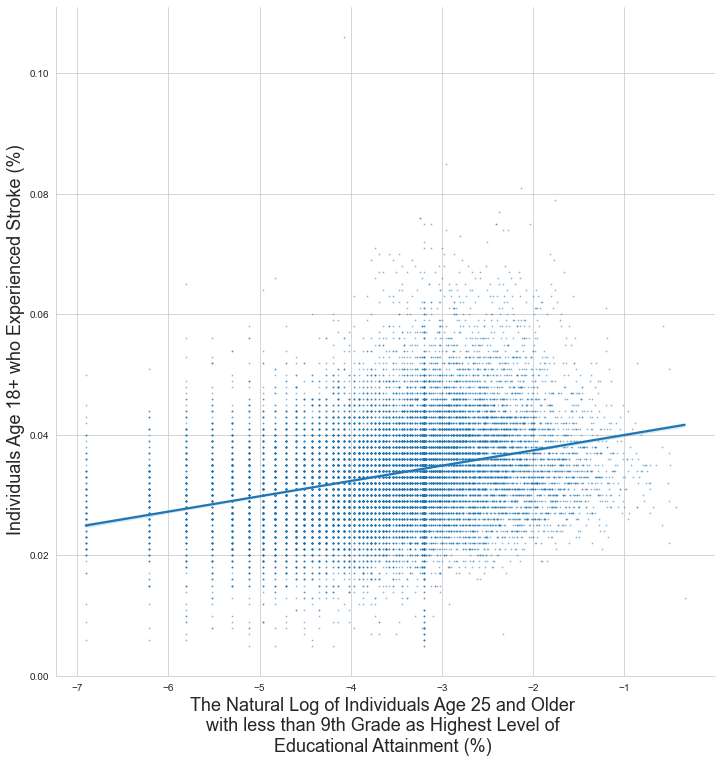

In [70]:
plot_relationship(X_train['Individuals Age 25 and Older with less than 9th Grade as Highest Level of Educational Attainment (%)'],
                  Y_train[Y_name],
                  X_transformation=log,
                  imp_val=0)

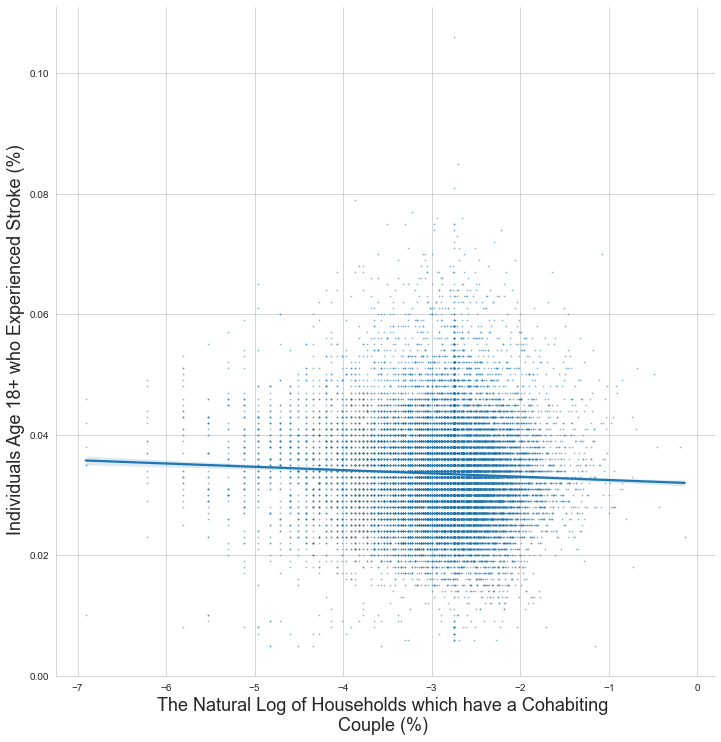

In [72]:
plot_relationship(X_train['Households which have a Cohabiting Couple (%)'],
                  Y_train[Y_name],
                  X_transformation=log,
                  imp_val=0)

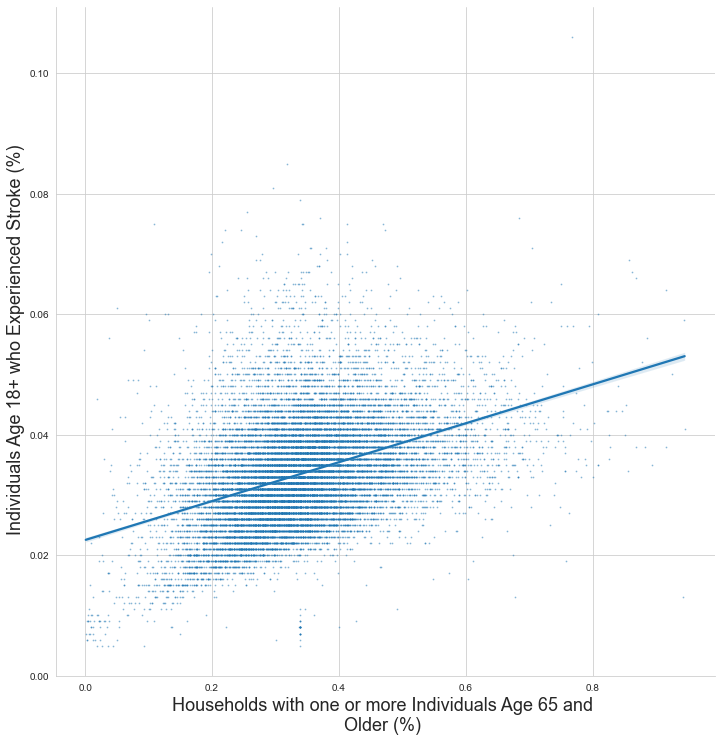

In [75]:
plot_relationship(X_train['Households with one or more Individuals Age 65 and Older (%)'],
                  Y_train[Y_name],
                  imp_val=0)

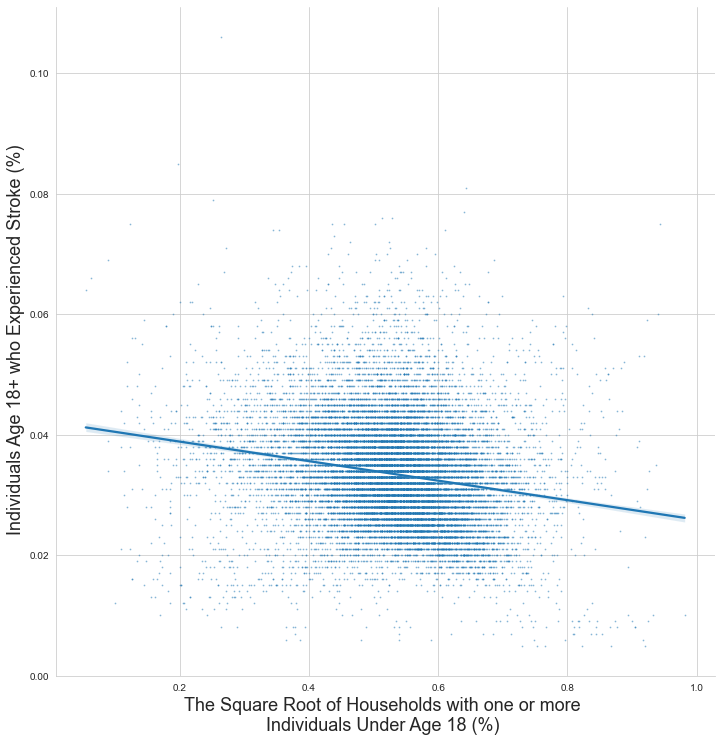

In [77]:
plot_relationship(X_train['Households with one or more Individuals Under Age 18 (%)'],
                  Y_train[Y_name],
                  X_transformation=square_root,
                  imp_val=0)

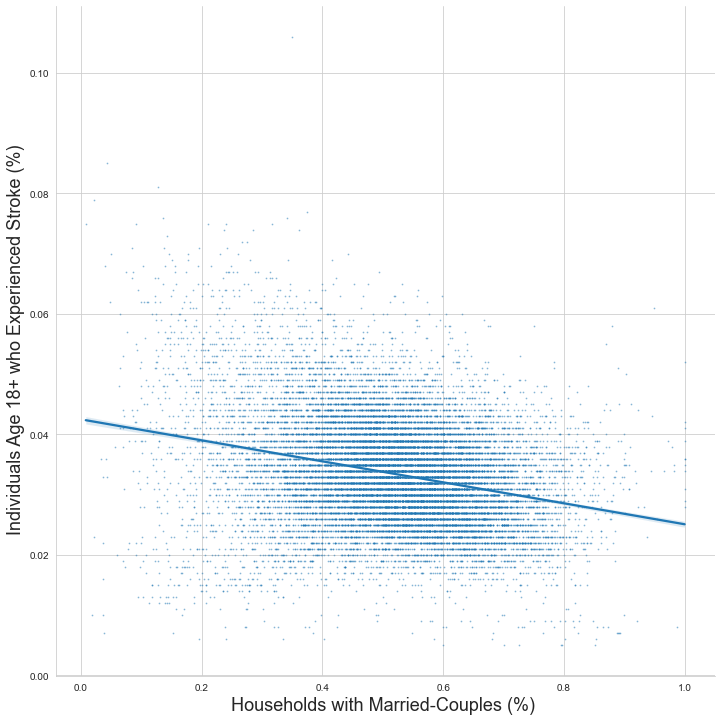

In [80]:
plot_relationship(X_train['Households with Married-Couples (%)'],
                  Y_train[Y_name],
                  imp_val=0)

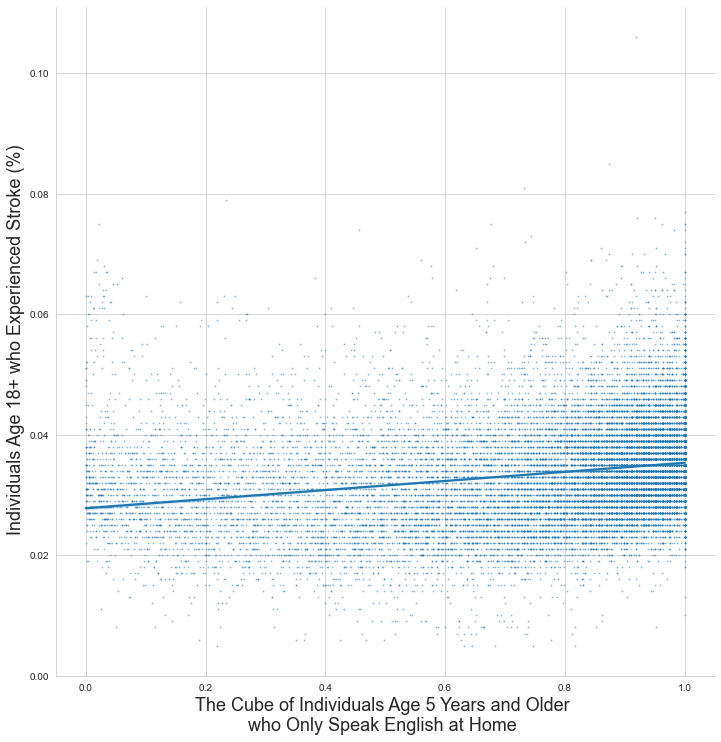

In [83]:
plot_relationship(X_train['Individuals Age 5 Years and Older who Only Speak English at Home'],
                  Y_train[Y_name],
                  X_transformation=cube,
                  imp_val=0)

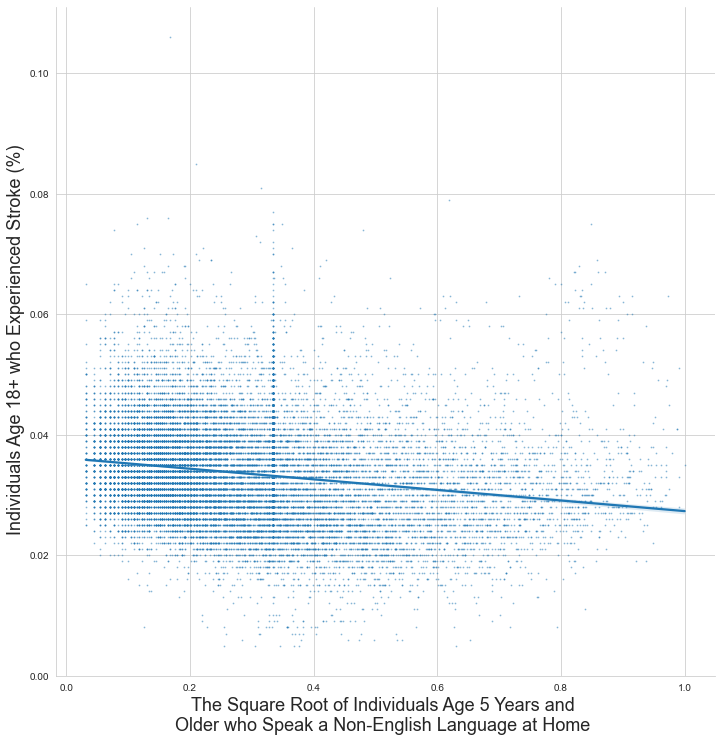

In [86]:
plot_relationship(X_train['Individuals Age 5 Years and Older who Speak a Non-English Language at Home'],
                  Y_train[Y_name],
                  X_transformation=square_root,
                  imp_val=0)

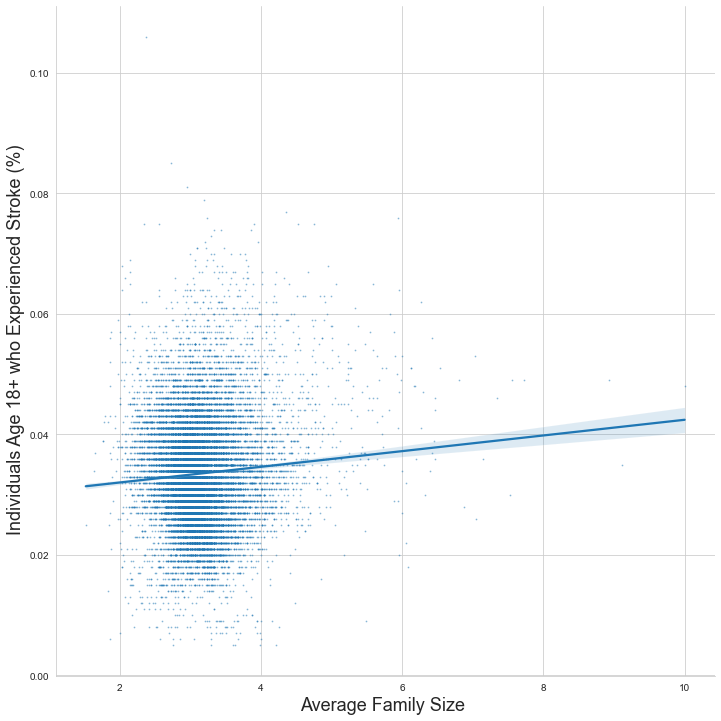

In [89]:
plot_relationship(X_train['Average Family Size'],
                  Y_train[Y_name],
                  imp_val=0)

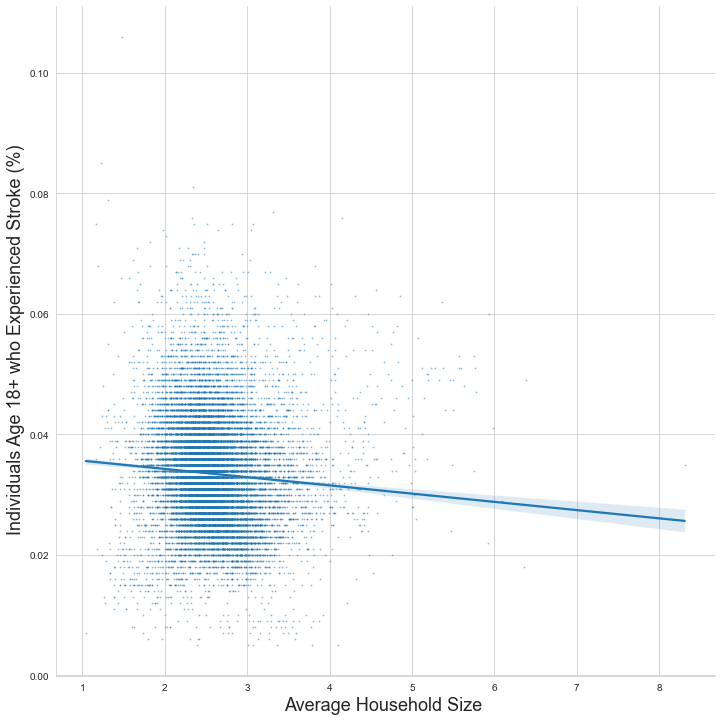

In [90]:
plot_relationship(X_train['Average Household Size'],
                  Y_train[Y_name],
                  imp_val=0)

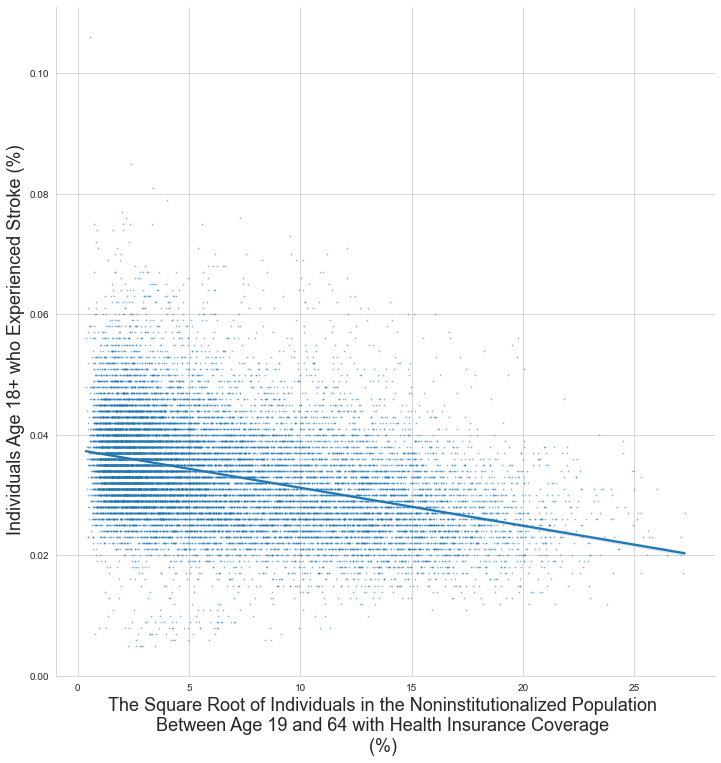

In [93]:
plot_relationship(X_train['Individuals in the Noninstitutionalized Population Between Age 19 and 64 with Health Insurance Coverage (%)'],
                  Y_train[Y_name],
                  X_transformation=square_root,
                  imp_val=0)

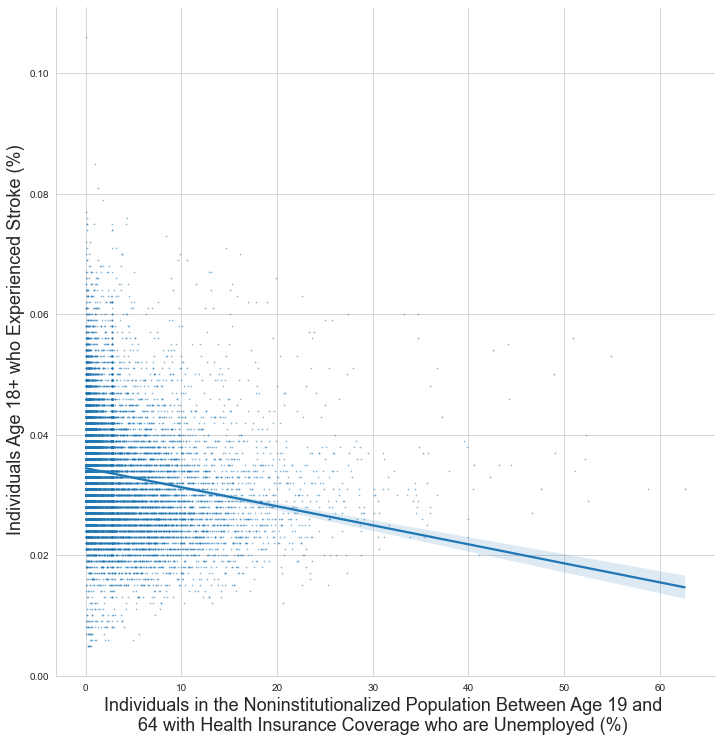

In [95]:
plot_relationship(X_train['Individuals in the Noninstitutionalized Population Between Age 19 and 64 with Health Insurance Coverage who are Unemployed (%)'],
                  Y_train[Y_name],
                  imp_val=0)

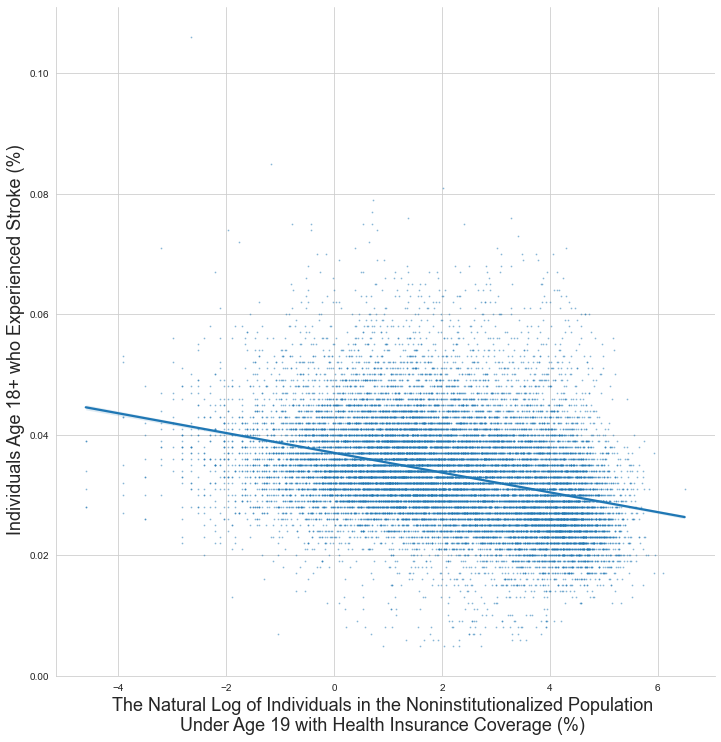

In [99]:
plot_relationship(X_train['Individuals in the Noninstitutionalized Population Under Age 19 with Health Insurance Coverage (%)'],
                  Y_train[Y_name],
                  X_transformation=log,
                  imp_val=0)

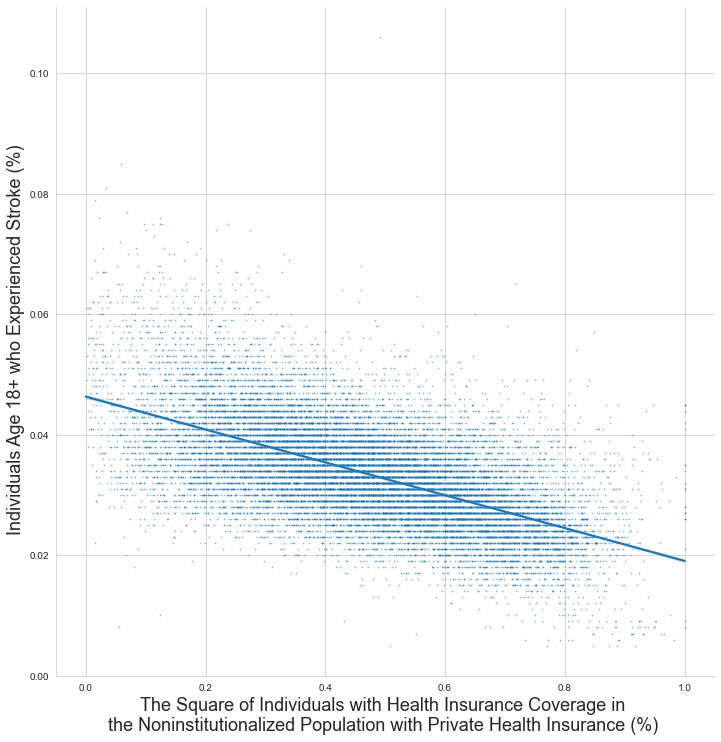

In [102]:
plot_relationship(X_train['Individuals with Health Insurance Coverage in the Noninstitutionalized Population with Private Health Insurance (%)'],
                  Y_train[Y_name],
                  X_transformation=square,
                  imp_val=0)

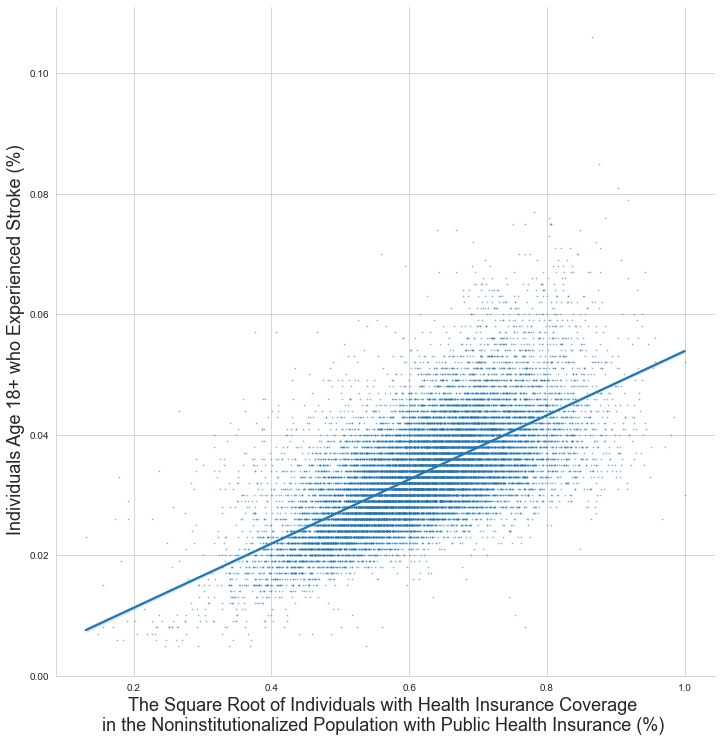

In [105]:
plot_relationship(X_train['Individuals with Health Insurance Coverage in the Noninstitutionalized Population with Public Health Insurance (%)'],
                  Y_train[Y_name],
                  X_transformation=square_root,
                  imp_val=0)

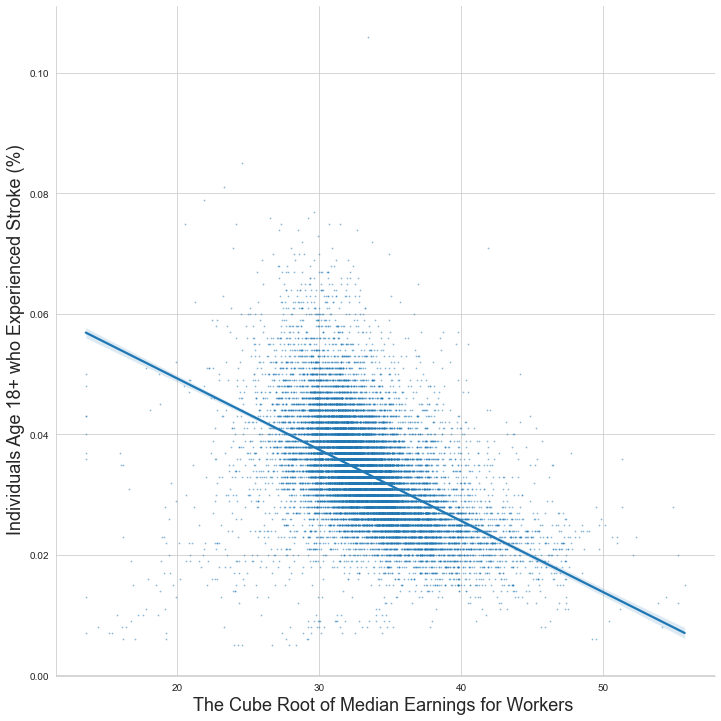

In [114]:
plot_relationship(X_train['Median Earnings for Workers'],
                  Y_train[Y_name],
                  X_transformation=cube_root,
                  imp_val=0)

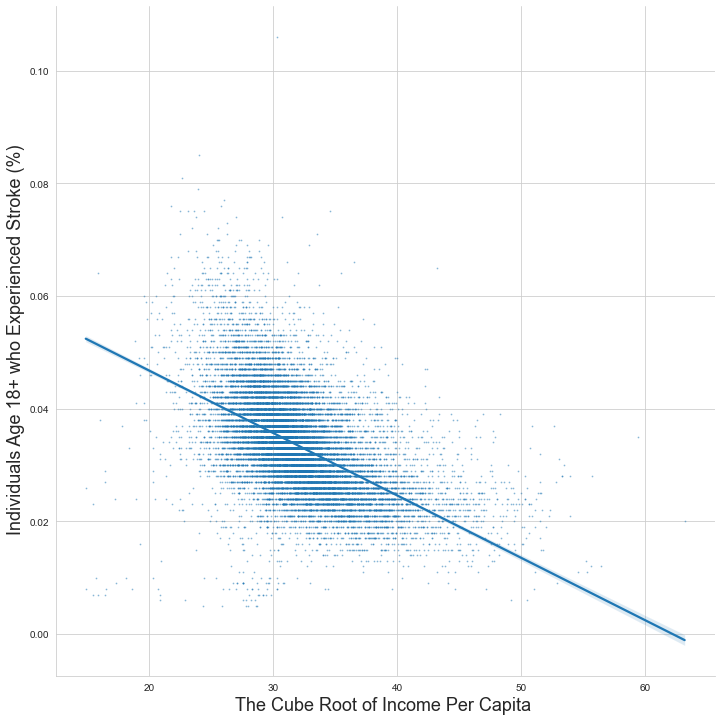

In [118]:
plot_relationship(X_train['Income Per Capita'],
                  Y_train[Y_name],
                  X_transformation=cube_root,
                  imp_val=0)

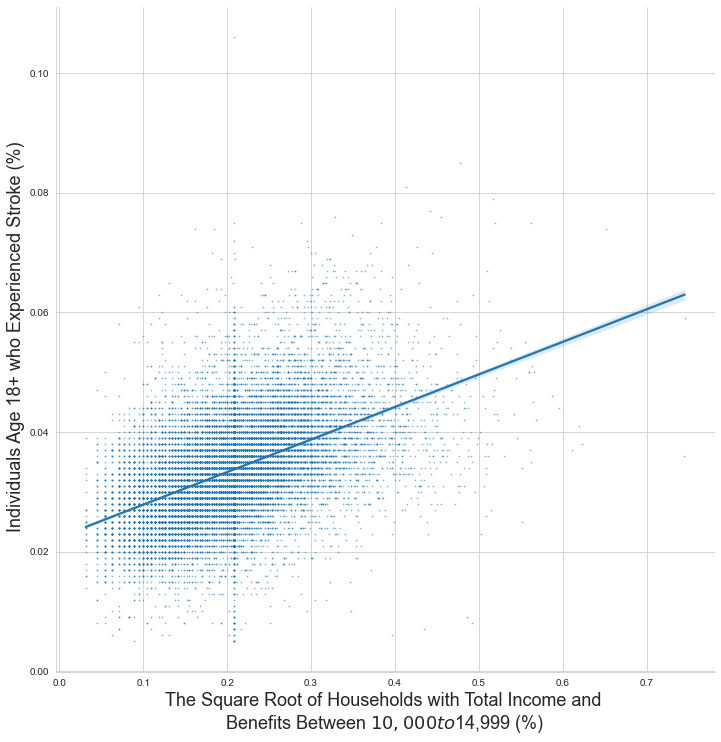

In [122]:
plot_relationship(X_train['Households with Total Income and Benefits Between $10,000 to $14,999 (%)'],
                  Y_train[Y_name],
                  X_transformation=square_root,
                  imp_val=0)

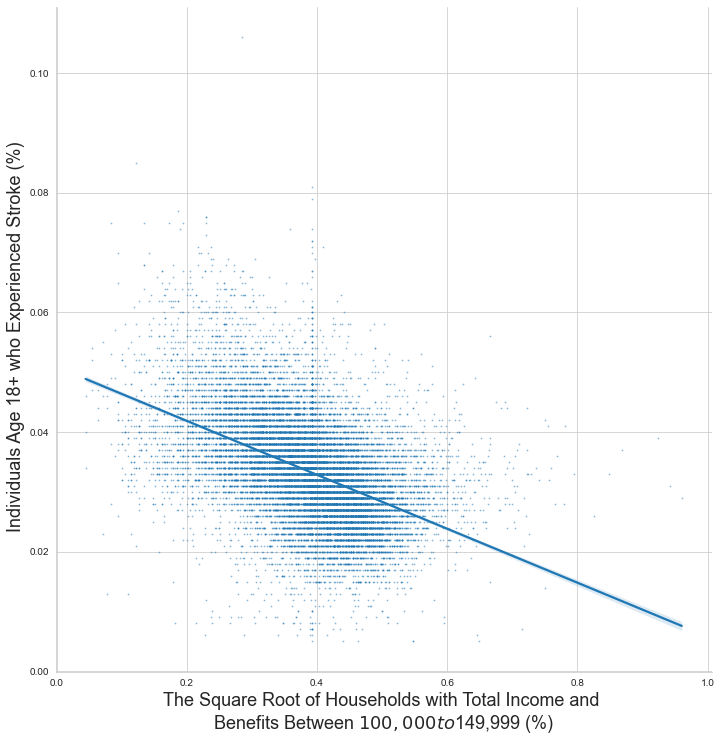

In [124]:
plot_relationship(X_train['Households with Total Income and Benefits Between $100,000 to $149,999 (%)'],
                  Y_train[Y_name],
                  X_transformation=square_root,
                  imp_val=0)

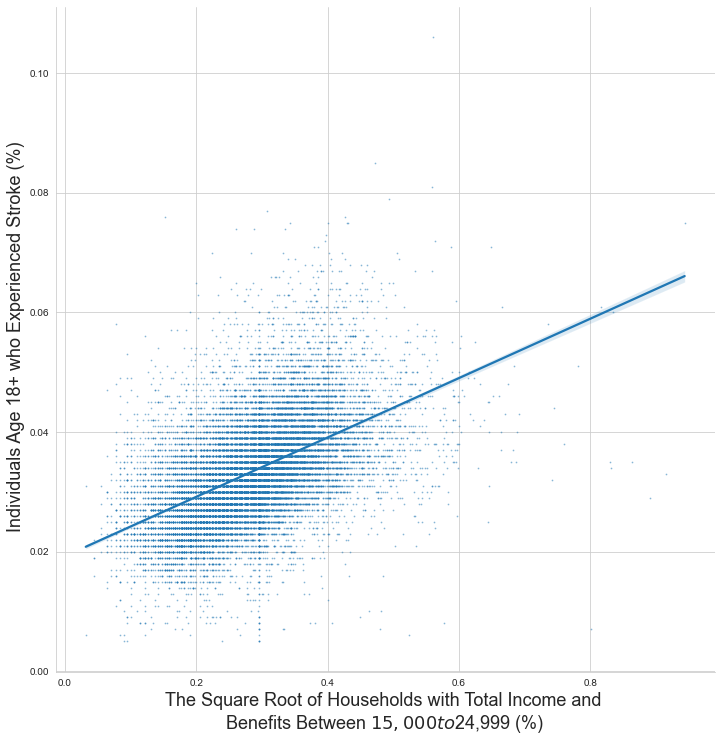

In [126]:
plot_relationship(X_train['Households with Total Income and Benefits Between $15,000 to $24,999 (%)'],
                  Y_train[Y_name],
                  X_transformation=square_root,
                  imp_val=0)

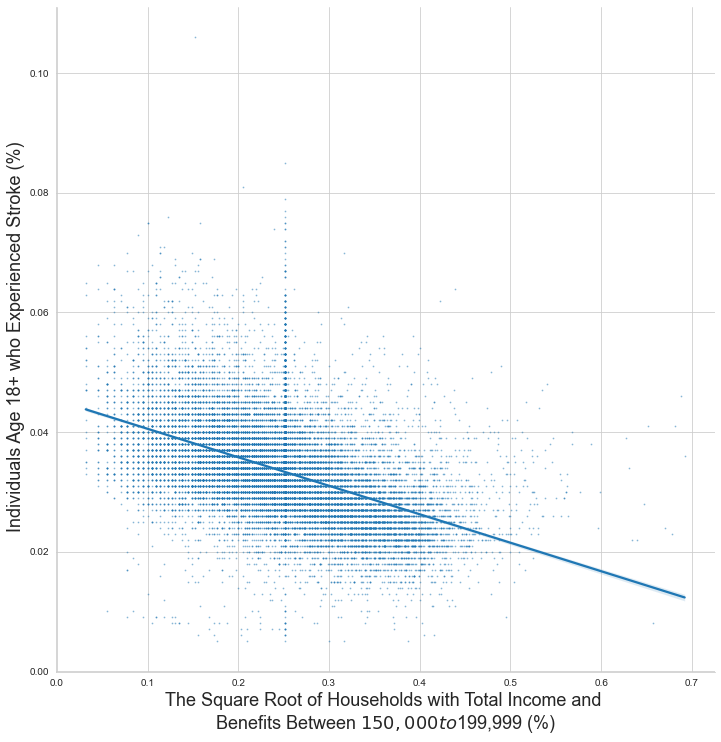

In [129]:
plot_relationship(X_train['Households with Total Income and Benefits Between $150,000 to $199,999 (%)'],
                  Y_train[Y_name],
                  X_transformation=square_root,
                  imp_val=0)

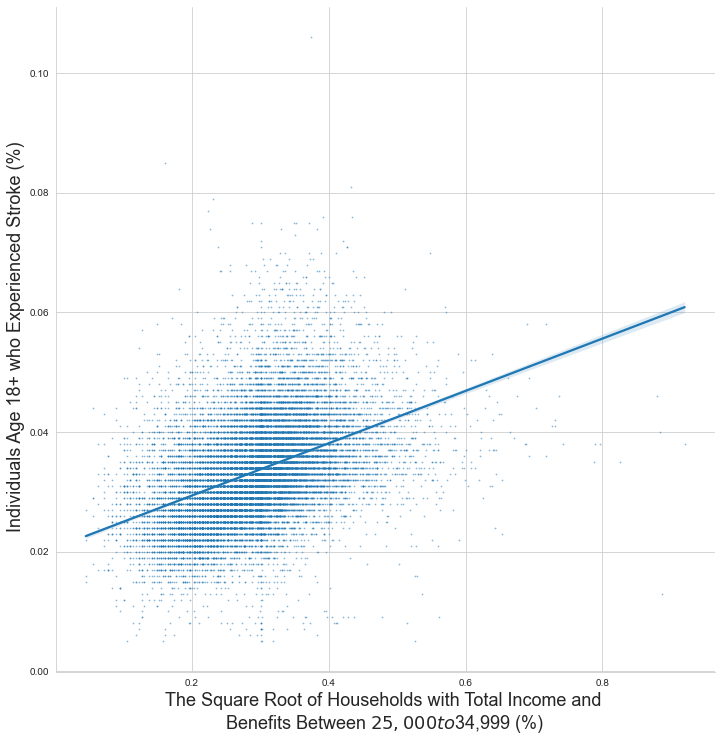

In [132]:
plot_relationship(X_train['Households with Total Income and Benefits Between $25,000 to $34,999 (%)'],
                  Y_train[Y_name],
                  X_transformation=square_root,
                  imp_val=0)

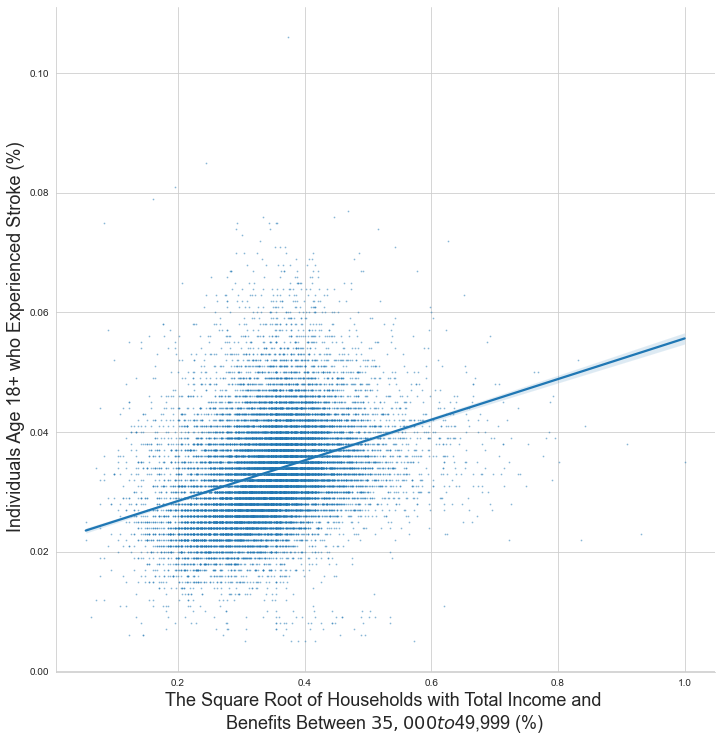

In [134]:
plot_relationship(X_train['Households with Total Income and Benefits Between $35,000 to $49,999 (%)'],
                  Y_train[Y_name],
                  X_transformation=square_root,
                  imp_val=0)

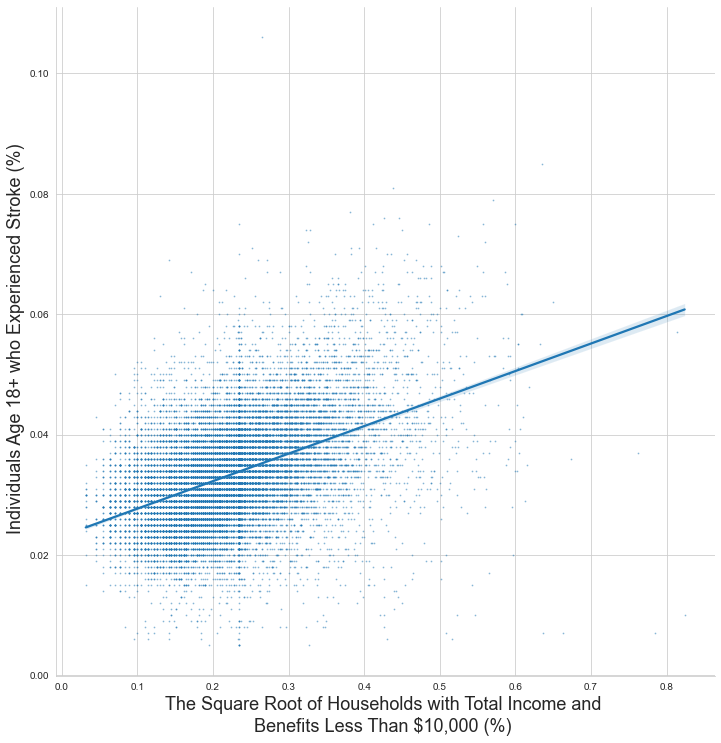

In [141]:
plot_relationship(X_train['Households with Total Income and Benefits Less Than $10,000 (%)'],
                  Y_train[Y_name],
                  X_transformation=square_root,
                  imp_val=0)

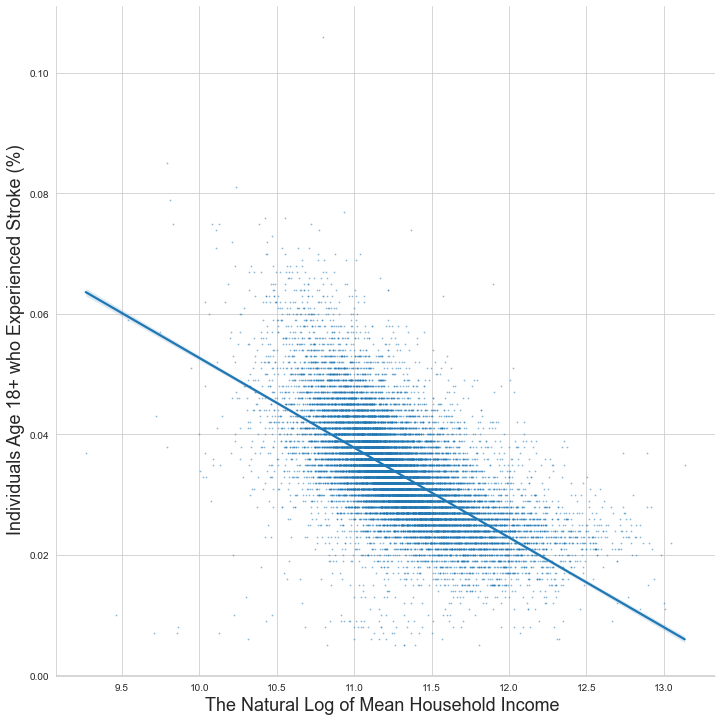

In [148]:
plot_relationship(X_train['Mean Household Income'],
                  Y_train[Y_name],
                  X_transformation=log,
                  imp_val=0)

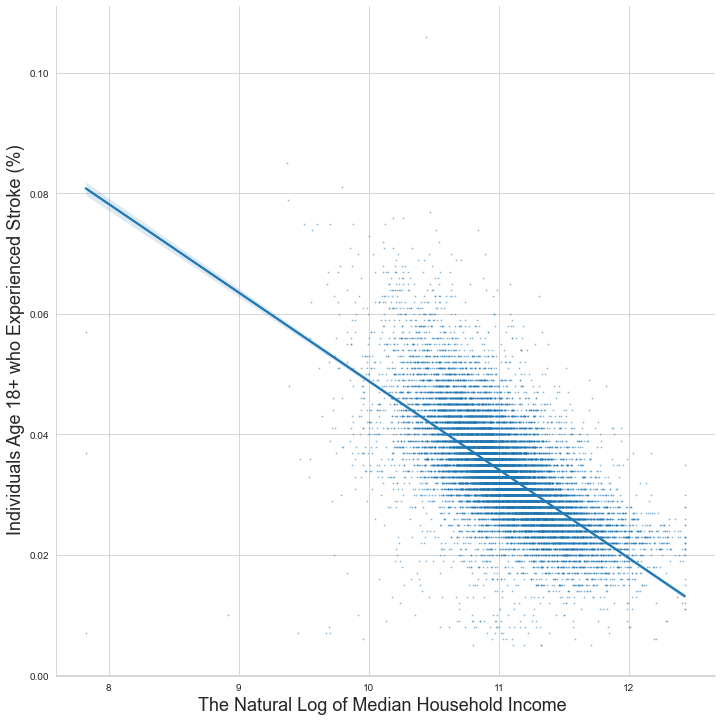

In [149]:
plot_relationship(X_train['Median Household Income'],
                  Y_train[Y_name],
                  X_transformation=log,
                  imp_val=0)

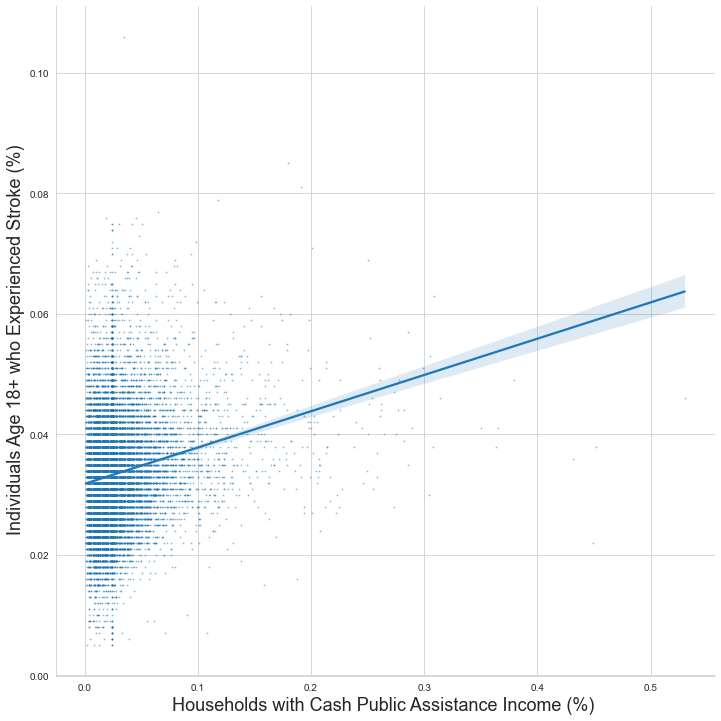

In [150]:
plot_relationship(X_train['Households with Cash Public Assistance Income (%)'],
                  Y_train[Y_name],
                  imp_val=0)

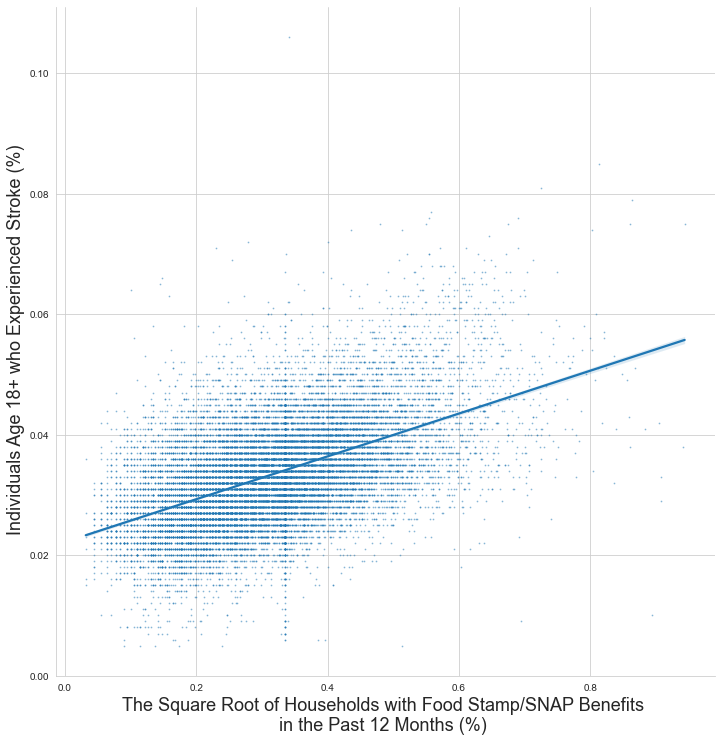

In [152]:
plot_relationship(X_train['Households with Food Stamp/SNAP Benefits in the Past 12 Months (%)'],
                  Y_train[Y_name],
                  X_transformation=square_root,
                  imp_val=0)

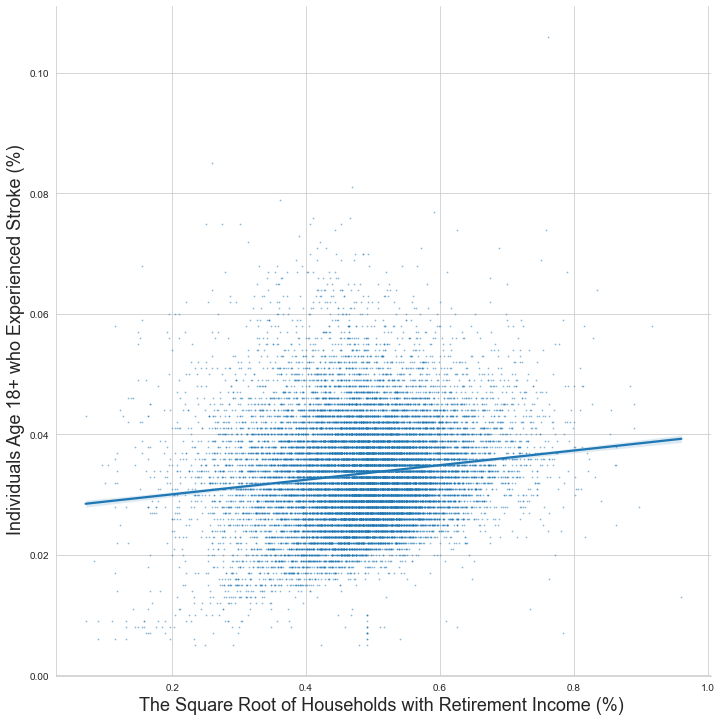

In [154]:
plot_relationship(X_train['Households with Retirement Income (%)'],
                  Y_train[Y_name],
                  X_transformation=square_root,
                  imp_val=0)

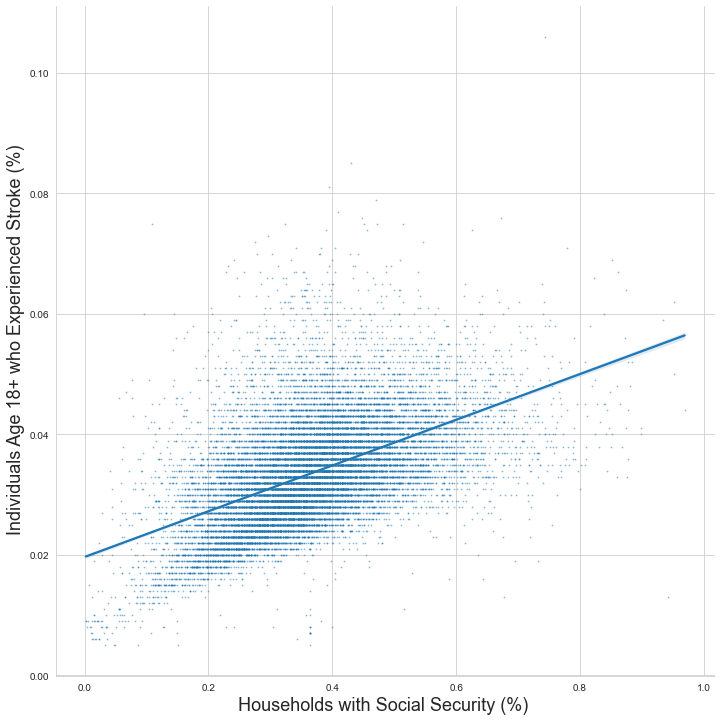

In [156]:
plot_relationship(X_train['Households with Social Security (%)'],
                  Y_train[Y_name],
                  imp_val=0)

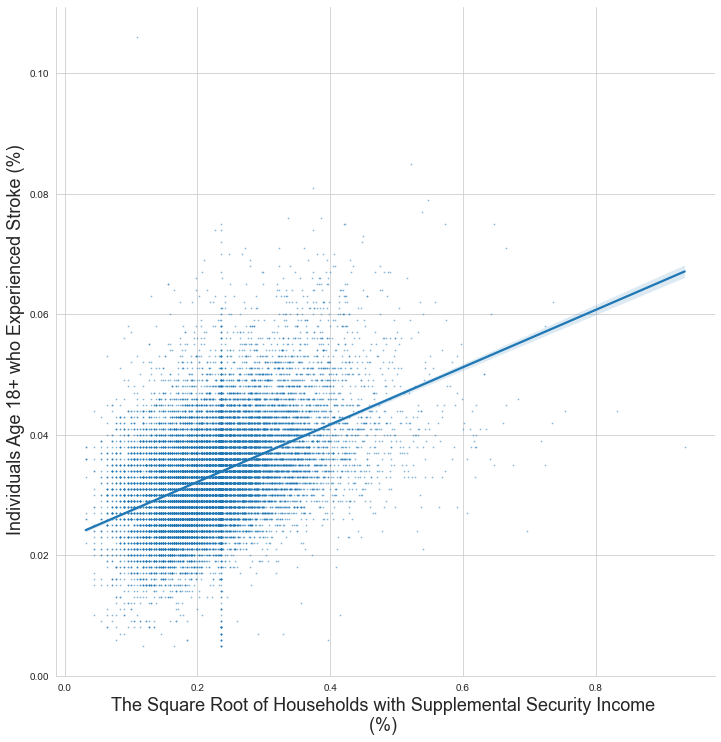

In [160]:
plot_relationship(X_train['Households with Supplemental Security Income (%)'],
                  Y_train[Y_name],
                  X_transformation=square_root,
                  imp_val=0)

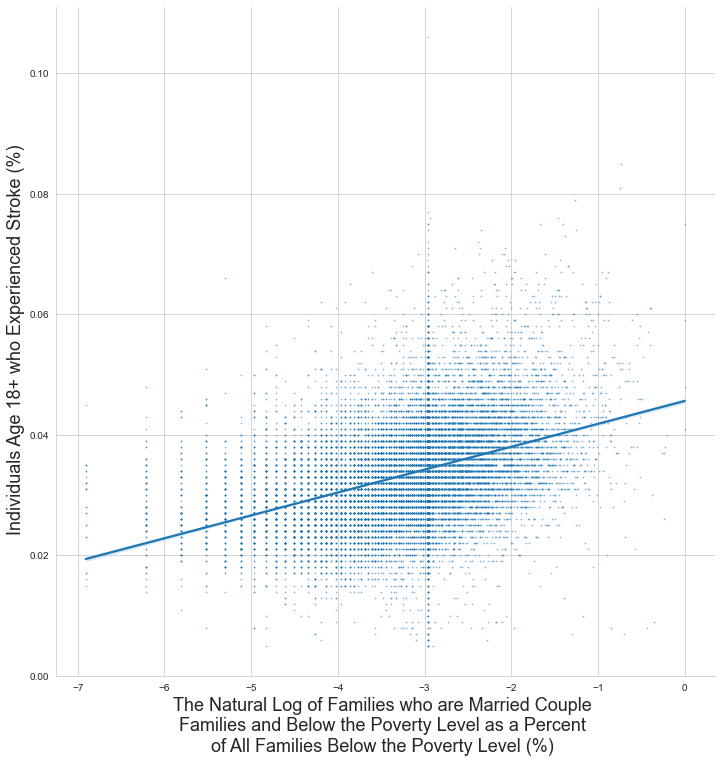

In [162]:
plot_relationship(X_train['Families who are Married Couple Families and Below the Poverty Level as a Percent of All Families Below the Poverty Level (%)'],
                  Y_train[Y_name],
                  X_transformation=log,
                  imp_val=0)

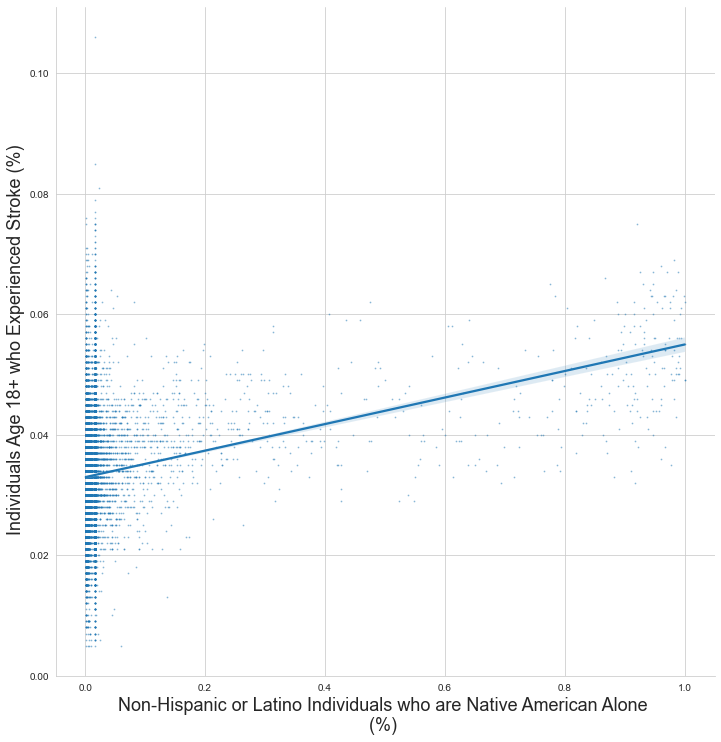

In [168]:
plot_relationship(X_train['Non-Hispanic or Latino Individuals who are Native American Alone (%)'],
                  Y_train[Y_name],
                  imp_val=0)

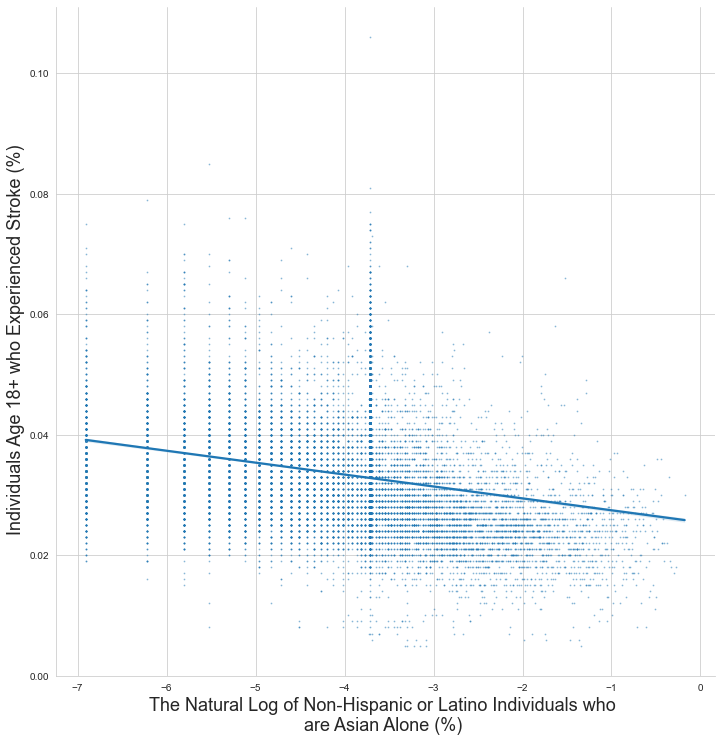

In [173]:
plot_relationship(X_train['Non-Hispanic or Latino Individuals who are Asian Alone (%)'],
                  Y_train[Y_name],
                  X_transformation=log,
                  imp_val=0)

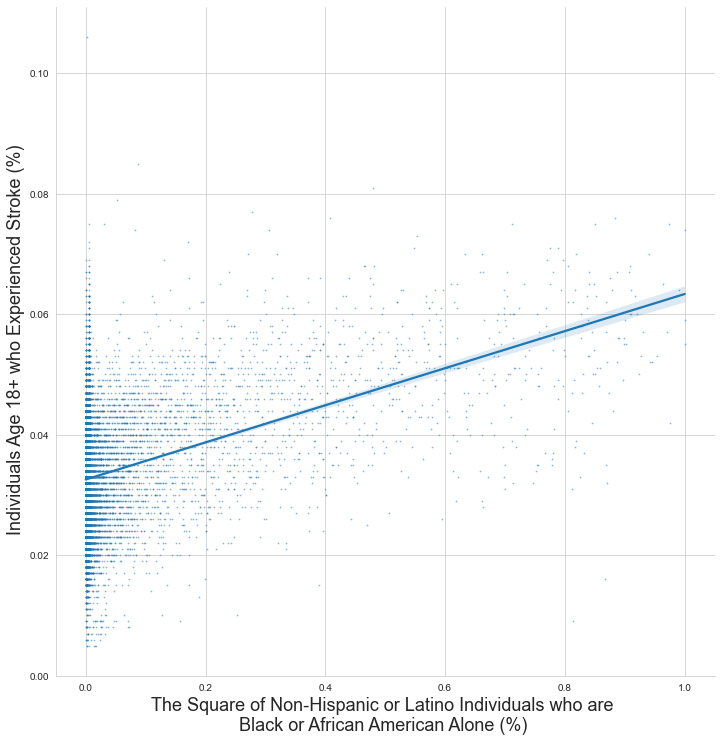

In [176]:
plot_relationship(X_train['Non-Hispanic or Latino Individuals who are Black or African American Alone (%)'],
                  Y_train[Y_name],
                  X_transformation=square,
                  imp_val=0)

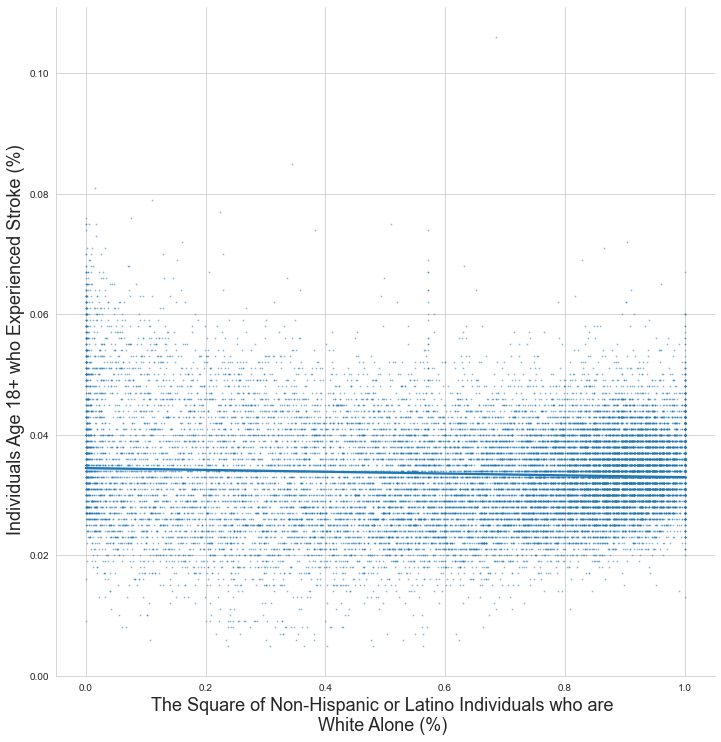

In [185]:
plot_relationship(X_train['Non-Hispanic or Latino Individuals who are White Alone (%)'],
                  Y_train[Y_name],
                  X_transformation=square,
                  imp_val=0)

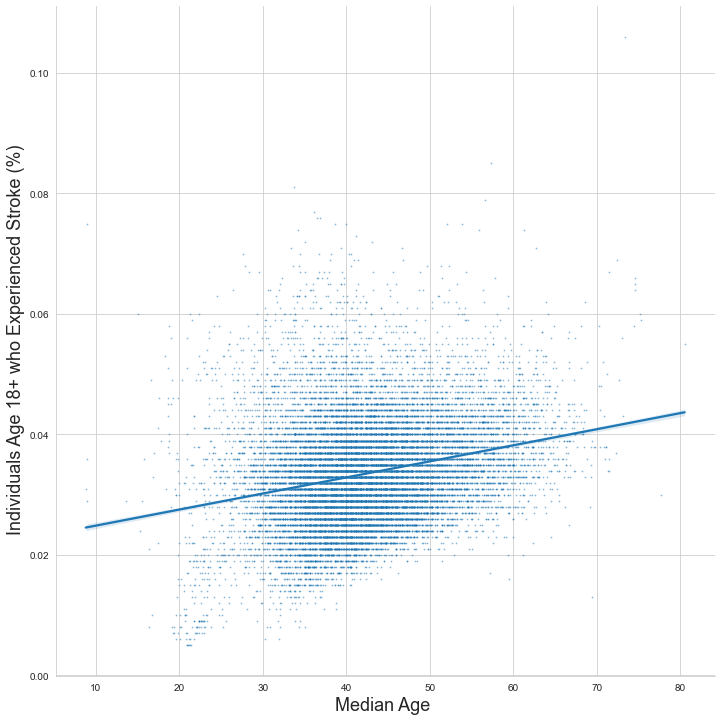

In [214]:
plot_relationship(X_train['Median Age'],
                  Y_train[Y_name],
                  imp_val=0)

<h2>Preprocessing and Model Training</h2>

In [215]:
def process_design_matrix(X, feature_set, is_test_set=False):
    """Completes the data engineering on the initial design matrix and returns the new design matrix to train the model on
    
    Parameters
    ----------
    X: DataFrame
        The unprocessed design matrix for the data
    
    is_test_set: boolean
        Whether or not the X dataframe is a test set
    
    Return Value
    ------------
    DataFrame
    """
    X = X.copy()
    
    # Selecting the features
    feature_list = get_features(feature_set)
    X = X[feature_list]
    
    # Add to this list as the processing is done for each feature in feature_set
    final_features = []
    
    # Processing for initial features
    if "initial" in feature_set:
        final_features.extend(initial_features)
        X["Broadband Cubed"] = X["Households with Broadband Internet Access (%)"] ** 3
        final_features.append("Broadband Cubed")
        
        X["Broadband Fourth"] = X["Households with Broadband Internet Access (%)"] ** 4
        final_features.append("Broadband Fourth")
        
        X["Broadband Fifth"] = X["Households with Broadband Internet Access (%)"] ** 5
        final_features.append("Broadband Fifth")        
        
        final_features.remove("Households with Broadband Internet Access (%)")
    
    # Processing for social_features
    if "social" in feature_set:
        X = impute(X, 'Households with a Computer (%)', 0)
        X["Computer (%) to the Twelfth"] = X["Households with a Computer (%)"] ** 12
        X = impute(X, 'Individuals in the Noninstitutionalized Population Between Age 18 and 64 with a Disability (%)', 0)
        X["Square Root 18-64 With a Disability"] = X['Individuals in the Noninstitutionalized Population Between Age 18 and 64 with a Disability (%)'] ** 0.5
        X = impute(X, 'Individuals in the Noninstitutionalized Population with a Disability (%)', 0)
        X["Cube Root Disability"] = X['Individuals in the Noninstitutionalized Population with a Disability (%)'] ** (1/3)
        X = impute(X, 'Individuals Age 25 and Older with 9th - 12th Grade, no Diploma as Highest Level of Educational Attainment (%)', 0)
        X["Square Root No Diploma"] = X['Individuals Age 25 and Older with 9th - 12th Grade, no Diploma as Highest Level of Educational Attainment (%)'] ** 0.5
        X = impute(X, "Individuals Age 25 and Older with a Bachelor's Degree as Highest Level of Educational Attainment (%)", 0)
        X["Square Root Bachelor's"] = X["Individuals Age 25 and Older with a Bachelor's Degree as Highest Level of Educational Attainment (%)"] ** 0.5
        X = impute(X, 'Individuals Age 5 Years and Older who Only Speak English at Home', 0)
        X["Cube English"] = X['Individuals Age 5 Years and Older who Only Speak English at Home'] ** 3
        X["Square English"] = X['Individuals Age 5 Years and Older who Only Speak English at Home'] ** 2
    
        final_features.append("Computer (%) to the Twelfth")
        final_features.append("Square Root 18-64 With a Disability")
        final_features.append("Cube Root Disability")
        final_features.append("Square Root No Diploma")
        final_features.append("Square Root Bachelor's")
        final_features.append('Individuals Age 25 and Older with a High School Diploma (or Equivalent) as Highest Level of Educational Attainment (%)')
        final_features.append('Households with one or more Individuals Age 65 and Older (%)')
        final_features.append('Households with one or more Individuals Under Age 18 (%)')
        final_features.append('Households with Married-Couples (%)')
        final_features.append('Individuals Age 5 Years and Older who Only Speak English at Home')
        final_features.append("Cube English")
        final_features.append("Square English")
        
    
    # Processing for economic features
    if "economic" in feature_set:
        X = impute(X, 'Individuals in the Noninstitutionalized Population Between Age 19 and 64 with Health Insurance Coverage (%)', 0)
        X["Square Root 19 - 64 Health Insurance"] = X['Individuals in the Noninstitutionalized Population Between Age 19 and 64 with Health Insurance Coverage (%)'] ** 0.5
        X = impute(X, 'Individuals in the Noninstitutionalized Population Under Age 19 with Health Insurance Coverage (%)', 0)
        X["Log Under 19 Health Insurance"] = np.log(X['Individuals in the Noninstitutionalized Population Under Age 19 with Health Insurance Coverage (%)'])
        X = impute(X, 'Individuals with Health Insurance Coverage in the Noninstitutionalized Population with Private Health Insurance (%)', 0)
        X["Square Private Health Insurance (%)"] = X['Individuals with Health Insurance Coverage in the Noninstitutionalized Population with Private Health Insurance (%)'] ** 2
        X = impute(X, 'Individuals with Health Insurance Coverage in the Noninstitutionalized Population with Public Health Insurance (%)', 0)
        X["Square Root Public Health Insurance (%)"] = X['Individuals with Health Insurance Coverage in the Noninstitutionalized Population with Public Health Insurance (%)'] ** 0.5
        X = impute(X, 'Median Earnings for Workers', 0)
        X["Cube Root Median Earnings for Workers"] = X['Median Earnings for Workers'] ** (1/3)
        X = impute(X, 'Income Per Capita', 0)
        X['Cube Root Income Per Capita'] = X['Income Per Capita'] ** (1/3)
        X = impute(X, 'Households with Total Income and Benefits Between $10,000 to $14,999 (%)', 0)
        X["Square Root 10,000 - 14,999"] = X['Households with Total Income and Benefits Between $10,000 to $14,999 (%)'] ** 0.5
        X = impute(X, 'Households with Total Income and Benefits Between $100,000 to $149,999 (%)', 0)
        X["Square Root 100,000 - 149,999"] = X['Households with Total Income and Benefits Between $100,000 to $149,999 (%)'] ** 0.5
        X = impute(X, 'Households with Total Income and Benefits Between $15,000 to $24,999 (%)', 0)
        X["Square Root 15,000 - 24,999"] = X['Households with Total Income and Benefits Between $15,000 to $24,999 (%)'] ** 0.5
        X = impute(X, 'Households with Total Income and Benefits Between $150,000 to $199,999 (%)', 0)
        X["Square Root 150,000 - 199,999"] = X['Households with Total Income and Benefits Between $150,000 to $199,999 (%)'] ** 0.5
        X = impute(X, 'Households with Total Income and Benefits Between $25,000 to $34,999 (%)', 0)
        X["Square Root 25,000 - 34,999"] = X['Households with Total Income and Benefits Between $25,000 to $34,999 (%)'] ** 0.5
        X = impute(X, 'Households with Total Income and Benefits Between $35,000 to $49,999 (%)', 0)
        X["Square Root 35,000 - 49,999"] = X['Households with Total Income and Benefits Between $35,000 to $49,999 (%)'] ** 0.5
        X = impute(X, 'Households with Total Income and Benefits Less Than $10,000 (%)', 0)
        X["Square Root Less than 10,000"] = X['Households with Total Income and Benefits Less Than $10,000 (%)'] ** 0.5
        X = impute(X, 'Mean Household Income', 0)
        X["Log Mean Household Income"] = np.log(X['Mean Household Income'])
        X = impute(X, "Median Household Income", 0)
        X["Log Median Household Income"] = np.log(X['Median Household Income'])
        X = impute(X, 'Households with Food Stamp/SNAP Benefits in the Past 12 Months (%)', 0)
        X["Square Root SNAP"] = X['Households with Food Stamp/SNAP Benefits in the Past 12 Months (%)'] ** 0.5
        X = impute(X, 'Households with Social Security (%)', 0)
        X = impute(X, 'Households with Supplemental Security Income (%)', 0)
        X["Square Root SSI"] = X['Households with Supplemental Security Income (%)']
        
        final_features.append("Square Root 19 - 64 Health Insurance")
        final_features.append("Log Under 19 Health Insurance")
        final_features.append("Square Private Health Insurance (%)")
        final_features.append("Square Root Public Health Insurance (%)")
        final_features.append('Individuals with Health Insurance Coverage in the Noninstitutionalized Population with Private Health Insurance (%)')
        final_features.append('Individuals with Health Insurance Coverage in the Noninstitutionalized Population with Public Health Insurance (%)')
        final_features.append('Median Earnings for Workers')
        final_features.append("Cube Root Median Earnings for Workers")
        final_features.append("Cube Root Income Per Capita")
        final_features.append("Square Root 10,000 - 14,999")
        final_features.append("Square Root 100,000 - 149,999")
        final_features.append("Square Root 15,000 - 24,999")
        final_features.append("Square Root 150,000 - 199,999")
        final_features.append("Square Root 25,000 - 34,999")
        final_features.append("Square Root 35,000 - 49,999")
        final_features.append("Square Root Less than 10,000")
        final_features.append("Log Mean Household Income")
        final_features.append("Log Median Household Income")
        final_features.append("Square Root SNAP")
        final_features.append('Households with Social Security (%)')
        final_features.append("Square Root SSI")
    
    # Processing for demographic features
    if "demographic" in feature_set:
        X = impute(X, 'Non-Hispanic or Latino Individuals who are Asian Alone (%)', 0)
        X["Log Asian Alone"] = np.log(X['Non-Hispanic or Latino Individuals who are Asian Alone (%)'])
        X["Square White Alone"] = X['Non-Hispanic or Latino Individuals who are White Alone (%)'] ** 2
        X["Square Black or African American Only"] = X['Individuals who are Black or African American Only (%)'] ** 2
        X["Square Root 75 - 85"] = X['Individuals Aged 75 to 85 (%)'] ** 0.5
        
        final_features.append('Non-Hispanic or Latino Individuals who are Native American Alone (%)')
        final_features.append("Log Asian Alone")
        final_features.append('Non-Hispanic or Latino Individuals who are Black or African American Alone (%)')
        final_features.append('Non-Hispanic or Latino Individuals who are White Alone (%)')
        final_features.append("Square White Alone")
        final_features.append('Individuals who are Cherokee Only (%)')
        final_features.append('Individuals who are Chippewa Only (%)')
        final_features.append('Individuals who are Navajo Only (%)')
        final_features.append('Individuals who are Asian Only (%)')
        final_features.append('Individuals who are Black or African American Only (%)')
        final_features.append("Square Black or African American Only")
        final_features.append('Individuals Aged 15 to 19 (%)')
        final_features.append('Individuals Aged 34 to 44 (%)')
        final_features.append('Individuals Aged 65 to 74 (%)')
        final_features.append("Square Root 75 - 85")
        final_features.append('Median Age')
    
    # Processing for the test set -- should NOT remove rows
    if is_test_set:
        pass
    elif not is_test_set:
        return X[final_features]

#Determining the RMSE of the model
train_model(process_design_matrix
            (
                X_train, 
                ["initial", "social", "economic", "demographic"]
            ), 
            Y_train[Y_name], 
            Y_transformation=no_transformation
        )

Training error: 0.004294132420326161
Fold 1 validation error: 0.004236072053767501
Fold 2 validation error: 0.004314748012663472
Fold 3 validation error: 0.004328842319192592
Fold 4 validation error: 0.0044196285004391885
Average Cross Validation Error: 0.004324822721515688


In [164]:
demographic_features

['Hispanic or Latino Individuals who are Cuban (%)',
 'Hispanic or Latino Individuals who are Mexican (%)',
 'Hispanic or Latino Individuals who are Puerto Rican (%)',
 'Non-Hispanic or Latino Individuals who are Native American Alone (%)',
 'Non-Hispanic or Latino Individuals who are Asian Alone (%)',
 'Non-Hispanic or Latino Individuals who are Black or African American Alone (%)',
 'Non-Hispanic or Latino Individuals who are Native Hawaiian and Other Pacific Islander Alone (%)',
 'Non-Hispanic or Latino Individuals who are some Other Race (%)',
 'Non-Hispanic or Latino Individuals who are Multiracial (%)',
 'Non-Hispanic or Latino Individuals who are White Alone (%)',
 'Individuals who are Cherokee Only (%)',
 'Individuals who are Chippewa Only (%)',
 'Individuals who are Navajo Only (%)',
 'Individuals who are Sioux Only (%)',
 'Individuals who are Monoracial (%)',
 'Individuals who are Asian Only (%)',
 'Individuals who are Indian Only (%)',
 'Individuals who are Chinese Only (%)'